Standard approach to the process flow

In [35]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, model_selection, neighbors, svm

# Open file
df = pd.read_csv("breast-cancer-wisconsin-original/breast-cancer-wisconsin.data", header=None)

# Name columns from breast-cancer-wisconsin.names
df.columns = ['id','clump_thickness','unif_cell_size','unif_cell_shape','marginal_adhesion','single_epith_cell_size', 'bare_nuclei', 'bland_chromatin','normal_nucleoli','mitoses', 'class']

# Handle missing data
df.replace('?',-99999, inplace=True)

# Select features
df.drop(['id'], axis=1, inplace=True)

# Define X and y
X = np.array(df.drop(['class'], axis=1))
y = np.array(df['class'])

# Splitting in train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

# Initialize model
clf = svm.SVC()

# Train model
clf.fit(X_train, y_train)

# Check accuracy using test
accuracy = clf.score(X_test, y_test)
print('Accuracy:', accuracy)

# Predict
example = [
    [4,2,1,1,1,2,3,2,1],
    [4,2,1,2,2,2,3,2,1]
]
example_measures = np.array(example).reshape(len(example),-1)
prediction = clf.predict(example_measures)
print("Prediction:", prediction)

Accuracy: 0.7071428571428572
Prediction: [2 2]


### SVM from Scratch

#### Optimization
- Minimize W
- Maximize b

Optimized a step
Optimized a step
Optimized a step
[1 7] : 1.2239999999999465
[2 8] : 1.2239999999999465
[3 8] : 1.000000000000098
[5 1] : 1.015999999998539
[ 6 -1] : 1.6879999999980846
[7 3] : 1.015999999998539


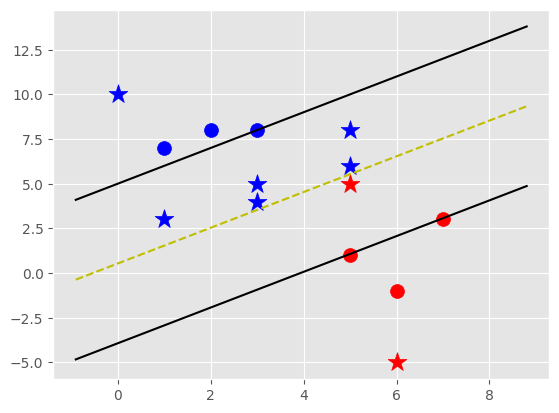

In [10]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot')

# Data
data_dict = {-1: np.array([[1,7],
                           [2,8],
                           [3,8],
                           ]),
             1: np.array([[5,1],
                          [6,-1],
                          [7,3],
                          ]) 
            }

# SVM Class
class Support_Vector_Machine():
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1: 'r', -1: 'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)

    # Train Model
    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}
        
        transforms = [
            [1, 1],
            [-1,1],
            [1, -1],
            [-1,-1]
        ]

        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None

        # Support vectors yi(xi.w + b) = 1
        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      # Point of being expensive
                      self.max_feature_value * 0.001,
                      ]

        # Extremely expensive
        b_range_multiple = 5

        # We don't need to take as small of steps with b as we do with w
        b_multiple = 5

        latest_optimum = self.max_feature_value * 10

        for step in step_sizes:
            w = np.array([latest_optimum, latest_optimum])

            # Convex optimization
            optimized = False

            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                    self.max_feature_value*b_range_multiple,
                                    step*b_multiple):
                    for transformation in transforms:
                        w_t = w * transformation
                        found_option = True
                        # Weakest link in SVM fundamentally, SMO attempts to fix this a bit\
                        # yi(xi.w+b) >= 1
                        for i in self.data:
                            for xi in self.data[i]:
                                yi = i
                                if not yi*(np.dot(w_t,xi)+b) >= 1:
                                    found_option = False
                                # print(xi,':',yi*(np.dot(w_t,xi)+b))
                        
                        if found_option:
                            opt_dict[np.linalg.norm(w_t)] = [w_t, b]

                if w[0] < 0:
                    optimized = True
                    print('Optimized a step')
                else:
                    # w = [5.5]
                    # step = 1
                    # w - step = [4,4]
                    w = w - step
            
            # Sort magnitudes
            norms = sorted([n for n in opt_dict])
            opt_choice = opt_dict[norms[0]]
            # ||w|| : [w,b]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0] + step * 2

        # print out data and calculation check
        for i in self.data:
            for xi in self.data[i]:
                yi = i
                print(xi,':',yi*(np.dot(self.w,xi)+self.b))

    # Predict
    def predict(self, features):
        # sign(x.w+b)
        classification = np.sign(np.dot(np.array(features), self.w) + self.b)
        if classification != 0 and self.visualization:
            self.ax.scatter(features[0], features[1], s=200, marker='*', c=self.colors[classification])
        return classification
    
    def visualize(self):
       [[ self.ax.scatter(x[0], x[1], s=100, color=self.colors[i]) for x in data_dict[i]] for i in data_dict]

        # hyperplane = x.w + b
        # v = x.w + b
        # psv = 1, nsv = -1, dec = 0
       def hyperplane(x,w,b,v):
            return (-w[0] * x - b + v) / w[1]
       
       datarange = (self.min_feature_value*0.9, self.max_feature_value*1.1)
       hyp_x_min = datarange[0]
       hyp_x_max = datarange[1]

       # w.x + b = 1 - positive support vector
       psv1 = hyperplane(hyp_x_min, self.w, self.b, 1)
       psv2 = hyperplane(hyp_x_max, self.w, self.b, 1)
       self.ax.plot([hyp_x_min, hyp_x_max], [psv1,psv2], 'k')

       # w.x + b = -1 - negative support vector
       nsv1 = hyperplane(hyp_x_min, self.w, self.b, -1)
       nsv2 = hyperplane(hyp_x_max, self.w, self.b, -1)
       self.ax.plot([hyp_x_min, hyp_x_max], [nsv1,nsv2], 'k')

       # w.x + b = 0 - decision boundary
       db1 = hyperplane(hyp_x_min, self.w, self.b, 0)
       db2 = hyperplane(hyp_x_max, self.w, self.b, 0)
       self.ax.plot([hyp_x_min, hyp_x_max], [db1,db2], 'y--')

       plt.show()


svm = Support_Vector_Machine()
svm.fit(data=data_dict)
predict_us = [[0,10],
              [1,3],
              [3,4],
              [3,5],
              [5,5],
              [5,6],
              [6,-5],
              [5,8]]

for p in predict_us:
    svm.predict(p)

svm.visualize()

#### Kernels

What is it?
- A similarity function
- Why don't we just use kernels as a classifier?

Why do we use kernel? 
- Transform non-linear data to another dimension and creating a nearly separable situation.

How is it done?
- Imputed features

     pcost       dcost       gap    pres   dres
 0: -2.0641e+01 -3.0040e+01  9e+02  2e+01  1e-14
 1: -3.9160e+00 -2.7361e+01  6e+01  1e+00  1e-14
 2: -2.2875e+00 -1.0972e+01  1e+01  1e-01  3e-15
 3: -2.1504e+00 -3.6061e+00  2e+00  1e-02  3e-15
 4: -2.3857e+00 -2.7763e+00  4e-01  3e-03  3e-15
 5: -2.4641e+00 -2.5703e+00  1e-01  6e-04  2e-15
 6: -2.4856e+00 -2.5268e+00  4e-02  2e-04  3e-15
 7: -2.4971e+00 -2.5094e+00  1e-02  4e-05  2e-15
 8: -2.5019e+00 -2.5029e+00  1e-03  3e-06  3e-15
 9: -2.5022e+00 -2.5024e+00  1e-04  3e-07  3e-15
10: -2.5023e+00 -2.5023e+00  2e-06  4e-09  3e-15
Optimal solution found.
38 support vectors out of 180 points
19 out of 20 predictions correct


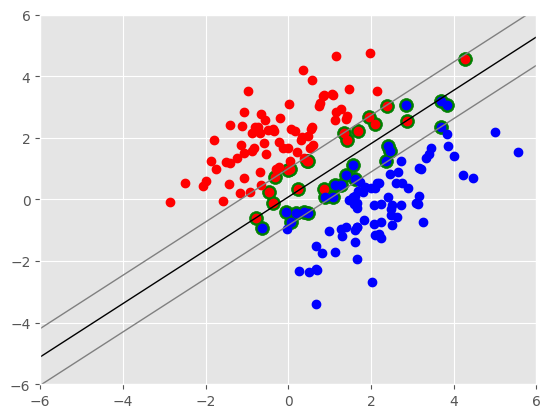

In [27]:
# Mathieu Blondel, September 2010
# https://mblondel.org/journal/2010/09/19/support-vector-machines-in-python/
# Github: https://gist.github.com/mblondel/586753
# CVXOPT: https://cvxopt.org/userguide/index.html

import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers

def linear_kernel(x1,x2):
    return np.dot(x1,x2)

def polynomial_kernel(x, y, p=3):
    return (1+ np.dot(x,y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp( -linalg.norm(x-y)**2 / ( 2 * (sigma ** 2) ) )

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print ("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

if __name__ == "__main__":
    import pylab as pl

    def gen_lin_separable_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[0.8, 0.6], [0.6, 0.8]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_non_lin_separable_data():
        mean1 = [-1, 2]
        mean2 = [1, -1]
        mean3 = [4, -4]
        mean4 = [-4, 4]
        cov = [[1.0,0.8], [0.8, 1.0]]
        X1 = np.random.multivariate_normal(mean1, cov, 50)
        X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 50)
        X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_lin_separable_overlap_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[1.5, 1.0], [1.0, 1.5]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def split_train(X1, y1, X2, y2):
        X1_train = X1[:90]
        y1_train = y1[:90]
        X2_train = X2[:90]
        y2_train = y2[:90]
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))
        return X_train, y_train

    def split_test(X1, y1, X2, y2):
        X1_test = X1[90:]
        y1_test = y1[90:]
        X2_test = X2[90:]
        y2_test = y2[90:]
        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))
        return X_test, y_test

    def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]

        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()

    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

    def test_linear():
        X1, y1, X2, y2 = gen_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM()
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print ("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_non_linear():
        X1, y1, X2, y2 = gen_non_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(polynomial_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print ("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_soft():
        X1, y1, X2, y2 = gen_lin_separable_overlap_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(C=0.1)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print ("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

    # test_linear()
    # test_non_linear()
    test_soft()

#### More than 2 groups to classify

Methods:
- One vs Rest (OVR)
- One vs One (OVO)

Pros & Cons:
- OVR: Dataset amount - imbalanced dataset
- OVO: Might counter the imbalanced dataset but still circumstantial

In [37]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
import pandas as pd
import numpy as np
from sklearn import preprocessing, model_selection, neighbors, svm

# Open file
df = pd.read_csv("breast-cancer-wisconsin-original/breast-cancer-wisconsin.data", header=None)

# Name columns from breast-cancer-wisconsin.names
df.columns = ['id','clump_thickness','unif_cell_size','unif_cell_shape','marginal_adhesion','single_epith_cell_size', 'bare_nuclei', 'bland_chromatin','normal_nucleoli','mitoses', 'class']

# Handle missing data
df.replace('?',-99999, inplace=True)

# Select features
df.drop(['id'], axis=1, inplace=True)

# Define X and y
X = np.array(df.drop(['class'], axis=1))
y = np.array(df['class'])

# Splitting in train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

# Initialize model
clf = svm.SVC(C=0.1, kernel='linear', probability=False, decision_function_shape='ovr')

# Train model
clf.fit(X_train, y_train)

# Check accuracy using test
accuracy = clf.score(X_test, y_test)
print('Accuracy:', accuracy)

# Predict
example = [
    [4,2,1,1,1,2,3,2,1],
    [4,2,1,2,2,2,3,2,1]
]
example_measures = np.array(example).reshape(len(example),-1)
prediction = clf.predict(example_measures)
print("Prediction:", prediction)

Accuracy: 0.9428571428571428
Prediction: [2 2]
